# Tunneling through a barrier

In Lecture 10, we developed some solutions for the stationary Schrödinger equation. We solved the harmonic oscillator or the particle in a box model. All of this did not give any dynamics of particles in potentials but rather a static picture. Today we would like to consider the time dependent Schrödinger equations which yields the dynamics of the system. We will develop a solution based on Fourier transforms, as we still have to practice that a bit.

In [526]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *
from scipy.sparse import diags
from scipy.fftpack import fft,ifft
from time import sleep,time
from scipy import sparse as sparse
from scipy.sparse import linalg as ln

from ipycanvas import MultiCanvas, hold_canvas,Canvas


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Schrödinger equation for the momentum

This time we want to solve the Schrödinger equation for some special situation i.e. a wave packet that travels towards a barrier.
We have written the Schrödinger equation before, but shortly need that again

\begin{equation}
i\hbar\frac{\partial \Psi(x,t)}{\partial t} = \left ( \frac{-\hbar^2 }{2m}\frac{\partial^2}{\partial x^2}+V(x,t) \right ) \Psi(x,t)
\end{equation}

While this is the Schrödinger equation in position space, we may also obtain a Schrödinger equation for the momentum (k-) space. To do so, we take the fourier transform of the wavefunction 

\begin{equation}
\tilde{\Psi}(k,t)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} \Psi(x,t)e^{-ikx} dx
\end{equation}

which yields the wavefunction in momentum space. 

We can also do that backwards to express the relation between the position space and the momentum space wavefunction.

\begin{equation}
\Psi(x,t)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty}\tilde{\Psi}(k,t)e^{ikx}dk
\end{equation}

If we insert the latter equation into the Schrödinger equation we onbtain 

\begin{equation}
i\hbar \frac{\partial \tilde{\Psi}}{\partial t}=\frac{\hbar^{2}k^{2}}{2m}\tilde{\Psi}+V\left (i\frac{\partial }{\partial k}\right ) \tilde{\Psi}
\end{equation}

which is exactly this Schrödinger equation in momentum space.



## Cranck Nicolson Solution

We will pursue two different numerical solutions. The first solution, will be equivalent to the solution of the diffusion equation we did in Lecture 7. Here we need to write our Hamilton operator as a matrix with the second derivative and the potential. Lets assume you know how to create this matrix also from the last lecture. 

Then we just need to get the time dependence, which we obtain from finite differences as

$$
\frac{\Psi(x,t+dt)-\Psi(x,t)}{dt}\approx -\frac{i}{\hbar} H\Psi(x,t)
$$

in the forward direction and and similarly

$$
\frac{\Psi(x,t+dt)-\Psi(x,t)}{dt}\approx -\frac{i}{\hbar}  H\Psi(x,t+dt)
$$

in the backward direcction.



Therefore 

$$
i\frac{\Psi(x,t+dt)-\Psi(x,t)}{dt}\approx \frac{1}{2i\hbar } H\Psi(x,t)+\frac{1}{2i\hbar} H\Psi(x,t+dt)
$$

or

$$
\left(1-\frac{dt}{2i\hbar} H\right)\Psi(x,t+dt)=\left(1+\frac{dt}{2i\hbar} H\right)\Psi(x,t)
$$

and finally

$$
\Psi(x,t+dt)=\left(1-\frac{dt}{2i\hbar} H\right)^{-1}\left(1+\frac{dt}{2i\hbar} H\right)\Psi(x,t)
$$

Once we have calculated the Matrix of the hamiltonian and have provided an initial wavepacket, we can immediately propagate the initial wavepacket to later times. This seems easy with what we learned earlier.

### Setup Domain

As usual we need to define a spatial domain and a timstep for the solution.

In [1042]:
N=500
x, dx = np.linspace(-100, 100, N, retstep=True)

dt=0.5

### Initial Conditions

Next we define the initial gaussian wavepacket with a certain momentum given by the wavenumber $k_{0}$.

In [1043]:
def gauss_x(x, sigma, x0, k0):
    return (np.exp(-0.5 * ((x - x0)/ sigma) ** 2 + 1j * x * k0)/(sigma * np.sqrt(np.pi)))

In [1044]:
k0=1.3
x0=-50
sigma0=5
psi= gauss_x(x, sigma0, x0, k0)
prob=np.abs(psi)**2
dx=x[1]-x[0]
psi=psi/np.sqrt(np.sum(prob)*dx)

### Matrix Setup

At first we define the potential energy landscape.

In [1045]:
barrier_width=5
barrier_height=1.
potential = np.array([barrier_height if 0.0 < x < barrier_width else 0.0 for x in x])

Then the Hamitonion made of the second derivative and the potential energy landscape.

In [1046]:
h_diag = np.ones(n_points) / dx**2 + potential
h_non_diag = np.ones(n_points - 1) * (-0.5 / dx**2)
hamiltonian = sparse.diags([h_diag, h_non_diag, h_non_diag], [0, 1, -1])

### Propagation Matrix

With the help of the hamiltonian we now define the matrices we have to multiply to the current wavefunction to obtain the wavefunction at the next timestep. 

In [1047]:
implicit = (sparse.eye(n_points) - dt / 2.0j * hamiltonian).tocsc()
explicit = (sparse.eye(n_points) + dt / 2.0j * hamiltonian).tocsc() 
evolution_matrix = ln.inv(implicit).dot(explicit).tocsr()

### Animation setup

With that, we are ready to show the simulation result in an animation

In [1048]:
prob = abs(psi)**2
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.xlim(-100,100)
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel(r'$|\Psi(x,t)|^2$')
plt.tight_layout()  
plt.plot(x,potential,'k')
#ax.plot(x,20*prob,'g')
plt.draw()

background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(x,20*prob,'g')[0]

plt.close() 

### Animation

In [1049]:
canvas = Canvas(width=800, height=300,sync_image_data=False)
display(canvas)

Canvas(height=300, width=800)

For the animation, we just loop over 1000 steps, where we just calculate the product of the evolution matrix and the wavefunction. 
In each step, we also take care of normalizing the wavefunction again.

In [1050]:
for i in range(1000):
    psi = evolution_matrix.dot(psi)
    prob = abs(psi)**2

    norm = sum(prob)
    prob /= norm
    psi /= norm**0.5
    fig.canvas.restore_region(background)
    ax.draw_artist(points)
    points.set_data(x,20*prob)

    fig.canvas.blit(ax.bbox)
    X = np.array(fig.canvas.renderer.buffer_rgba())

    with hold_canvas(canvas): 
        canvas.clear()
        canvas.put_image_data(X)
        sleep(0.02)

<img src="cranck_nicolson_animation.mov" width="600">

## Split Step Method

If we look at bit closer at the two Schrödinger equations in real and momentum space above, we recognize that there is some symmetry in the two Schrödinger equations, which we can use to calculate the time-dependence of the wave function. This type of method is called the split step method.

We may substitute in the right side of the position Schrödinger equation 

\begin{equation}
\hat{D}=\frac{-\hbar^2 }{2m}\frac{\partial^2}{\partial x^2}
\end{equation}

and 

\begin{equation}
\hat{N}=V(x,t) 
\end{equation}

such that 

$$
i\hbar\frac{\partial \Psi(x,t)}{\partial t} = [\hat{D}+\hat{N}]\Psi
$$

with the solution 

$$
\Psi(x,t)=e^{-i(\hat{D}+\hat{N})t/\hbar}\Psi(x,0)
$$


If we only make a small timestep $dt$, we can write the latter equation also as

$$
\Psi(x,t+dt)=e^{-i\hat{D}dt/\hbar}e^{-i\hat{N}dt/\hbar} \Psi(x,t)
$$


We may now turn to momentum space by taking the Fourier transform $F$

$$
\tilde{\Psi}(k,t+dt)=F\left [e^{-i\hat{D}dt/\hbar}e^{-i\hat{N}dt/\hbar}\right ]\tilde{\Psi}(k,t)
$$

What we know now from the momentum Schrödinger equation is that the operator $\hat{D}$ will just turn into a multiplication with $\hbar k^2/2m$ in momentum space and therefore 

$$
\tilde{\Psi}(k,t+dt)=e^{i\frac{\hbar k^2}{2m}dt}F\left [e^{-i\hat{N}dt/\hbar}\right ]\tilde{\Psi}(k,t)
$$

Thus if we just do the inverse Fourier transform of that, we obtain

$$
\Psi(x,t+dt)=F^{-1}\left [ e^{i\frac{\hbar k^2}{2m}dt} F\left [e^{-i\hat{N}dt/\hbar}\Psi(x,t) \right ]  \right]
$$


This is the receipe for the solution of the time dependent Schrödinger equation. We will do this simulation with the help of the FFT we considered already earlier.

### Setup Domain

We first need to setup our domain together with the time resolution. 

In [966]:
#some constants
hbar=1
m=1

In [967]:
## spatial domain
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

In [1004]:
## timestep of our simulation
dt = 0.005

### Potential energy landscape

We want to study the tunneling of a wavepacket through a barrier, so we need to define a potential energy landscape, which contains two extremely high barriers at the left and the right side and in the middle a smaller barrier through which we can tunnel.

In [1005]:
## potential barrier height
V0 = 1

## potential barrier width
a=5

# potential barrier 
V_x = np.array([V0 if 0.0 < x < a else 0.0 for x in x])
V_x[np.abs(x) > 98] = 1e6

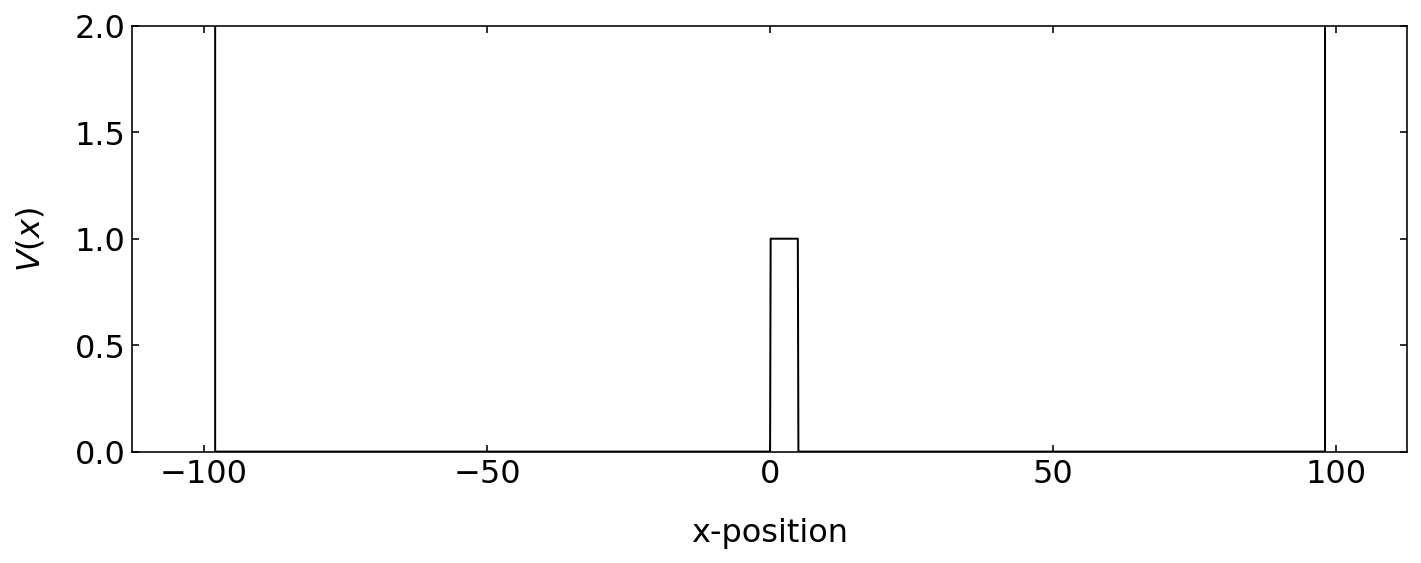

In [1006]:
plt.figure(figsize=(10,4))
plt.plot(x,V_x,'k')
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel('$V(x)$')
plt.tight_layout()
plt.show()

###  Initial wavepacket

Our initial wavepacket will be a Gaussian wavepacket, which is centered at $x_0=-50$.

In [1007]:
k0=1.3
x0=-50
sigma0=5
psi= gauss_x(x, sigma0, x0, k0)
prob=np.abs(psi)**2
dx=x[1]-x[0]
psi=psi/np.sqrt(np.sum(prob)*dx)

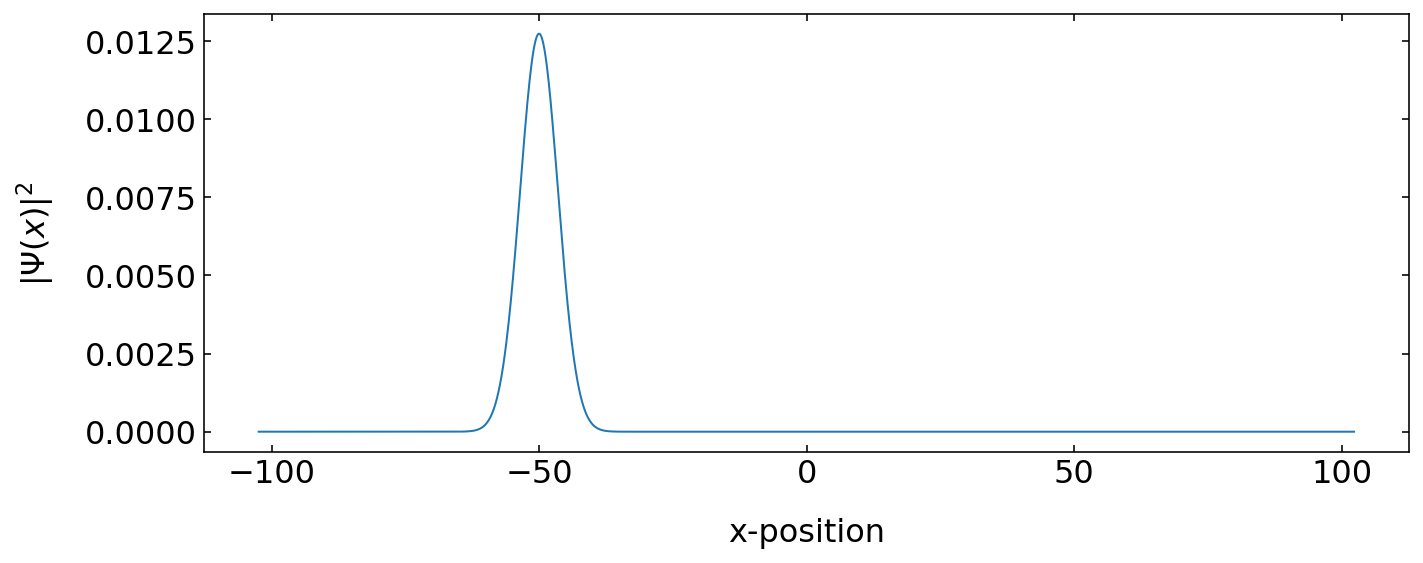

In [1008]:
plt.figure(figsize=(10,4))
plt.plot(x,np.abs(psi_x0)**2)
plt.xlabel('x-position')
plt.ylabel('$|\Psi(x)|^2$')
plt.tight_layout()
plt.show()

### Fourier Transform Setup

When doing the Fourier transform we switch between the spatial and the momentum domain. We will use for that purpose the Fast Fourier Transform Function as we did already earlier. As compared to what has been written in the equations above, that means we switch to a discrete space and miss some of the frequencies which would be contained in the analytical calculations above. To correct for the discrete sampling, we need to introduce a correction factor, which I leave to you for exploration.

The wavefunction we have to use is 

$$
\Psi_{\rm mod}=\Psi(x_{n},t)\frac{dx}{\sqrt{2\pi}}e^{-ik_{0}x}
$$

where $k_{0}=-\pi/dx$, which is the Nyquist limit. Note that this $k_0$ is not related to the $k_0$ of the wavepacket above. Here we define the space for the Fourier transform.

In [1009]:
N=len(x)
dx=x[1]-x[0]
k0=-np.pi/dx
dk = 2*np.pi / (N * dx)
k = k0 + dk * np.arange(N)

So the modified Gaussian wavepacket for the Fourier transform is

In [1010]:
psi_modx=psi_x0*np.exp(-1j * k[0] * x)* dx / np.sqrt(2 * np.pi)

### Phase Factor per Timestep

According to our calculations we first have evolve the wavepacket with a phase factor containing $\hat{N}$ which contains the potential and later with $\hat{D}$. 

$$
\Psi(x,t+dt)=F^{-1}\left [ e^{i\frac{\hbar k^2}{2m}dt} F\left [e^{-iV(x)dt/\hbar}\Psi(x,t) \right ]  \right]
$$


Both are just phases factors, which stay the same for each timestep. We may thus calculate them one, and reuse them.


In [1011]:
phase_x=np.exp(-1j*V_x*dt/hbar)
phase_k=np.exp(-1j*hbar*k**2/m*dt)

### Animation setup

In [1012]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.xlim(-100,100)
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel(r'$|\Psi(x,t)|^2$')
plt.tight_layout()  
plt.plot(x,V_x,'k')
plt.draw()

background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(x,np.abs(psi_modx)**2,'g')[0]

plt.close() 

In [1013]:
## setup the canvas
canvas = Canvas(width=800, height=300,sync_image_data=False)
display(canvas)

Canvas(height=300, width=800)

### Animation

The animation runs in the same way as before. 

In [1014]:
for i in range(1000):
    fig.canvas.restore_region(background)
    ax.draw_artist(points)
    for j in range(100):
        tmp=ifft(phase_k*fft(psi_modx*phase_x))
        psi_modx=tmp
        prob = abs(psi_modx)**2

        norm = sum(prob)
        prob /= norm
        psi_modx /= norm**0.5
    points.set_data(x,20*prob)    
    #points.set_data(x,1e5*np.abs(psi_modx)**2)

    fig.canvas.blit(ax.bbox)
    X = np.array(fig.canvas.renderer.buffer_rgba())

    
    with hold_canvas(canvas): 
        canvas.clear()
        canvas.put_image_data(X)
        sleep(0.01)

<img src="split_step_animation.mov" width="600">

# Where to go from here?

We have developed two schemes of how to solve the Schrödinger equation for the tunneling case. You may wanto to explore the wavefunction of the particle in momentum space, i.e. its Fourier transform to the k-space. This gives an idea on how the momentum changes upon reflection and transmission. 

You can also have a look at the transmitted and reflected wave amplitudes as a function of the height an the width of the barrier.

Finally, you may want to change the potential energy landscape.